# Preset filters

In this exercise, we will try to improve the model performance by giving the model additional features as input.
Here, we will use simple convolutional features and pass them as input to the MLP model from the previous
exercise.

As we have seen in the lecture, the approach of first computing predefined features and then passing them to a shallow classifier was a popular computer vision approach before deep learning.
Note that more sophisiticated features would be required to improve the classification results significantly.

Here, we will just sketch out this approach using simple features and make the connection to convolutional neural networks (the main topic of the exercises tomorrow) by expressing these features as convolutional layers in pytorch. 

## Preparation

In [1]:
# load tensorboard extension
%load_ext tensorboard

In [2]:
# import torch and other libraries
import os
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

In [3]:
!pip install cifar2png

In [4]:
# check if we have gpu support
# colab offers free gpus, however they are not activated by default.
# to activate the gpu, go to 'Runtime->Change runtime type'. 
# Then select 'GPU' in 'Hardware accelerator' and click 'Save'
have_gpu = torch.cuda.is_available()
# we need to define the device for torch, yadda yadda
if have_gpu:
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

GPU is available


In [5]:
# run this in google colab to get the utils.py file
!wget https://raw.githubusercontent.com/constantinpape/training-deep-learning-models-for-vison/master/day1/utils.py 

--2020-10-08 13:41:49--  https://raw.githubusercontent.com/constantinpape/training-deep-learning-models-for-vison/master/day1/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14228 (14K) [text/plain]
Saving to: ‘utils.py.2’

100%[======================================>] 14.228      --.-K/s   in 0,001s  

2020-10-08 13:41:49 (18,5 MB/s) - ‘utils.py.2’ saved [14228/14228]



In [6]:
# we will reuse the training function, validation function and
# data preparation from the previous notebook
import utils

In [7]:
cifar_dir = './cifar10'
!cifar2png cifar10 cifar10

output dir `cifar10` already exists. Please specify a different output path


In [8]:
categories = os.listdir('./cifar10/train')
categories.sort()

In [9]:
images, labels = utils.load_cifar('./cifar10/train')
train_images, train_labels, val_images, val_labels = utils.make_cifar_train_val_split(images, labels)

100%|██████████| 10/10 [01:27<00:00,  8.78s/it]


In [10]:
test_images, test_labels = utils.load_cifar('./cifar10/test')

100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


## Adding Filters as input features

Now we will compute two convolutional filters on top of the input image and stack their response with the input image to provide a larger input feature space.
We will use the `gaussian smoothing` and `laplacian` filters, making use of the impelemtations in [skimage.filters](https://scikit-image.org/docs/dev/api/skimage.filters.html).

In order to apply the filters and add them to the input space, we will reuse the transorm mechanism we have implemented in `DatasetWithTransform` earlier.

In [11]:
# apply a list of filters as on the fly transformation and stack the results along the channel axis
# optionally keep the original input image
def apply_filters(image, target, filter_list, keep_image=True):    
    filtered = [image] if keep_image else [] 
    for filter_function in filter_list:
        filtered.append(filter_function(image))
    data = np.concatenate(filtered, axis=-1)
    return data, target

In [12]:
# build dataset with filter transformations
from functools import partial
import skimage.filters as sk_filters

filters = [sk_filters.gaussian, sk_filters.laplace]
filters = partial(apply_filters, filter_list=filters,
                  keep_image=True)

trafos = [
    utils.normalize,
    filters,
    utils.to_channel_first,
    utils.to_tensor
]
trafos = partial(utils.compose, transforms=trafos)

train_dataset = utils.DatasetWithTransform(train_images, train_labels,
                                           transform=trafos)
val_dataset = utils.DatasetWithTransform(val_images, val_labels,
                                         transform=trafos)

/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


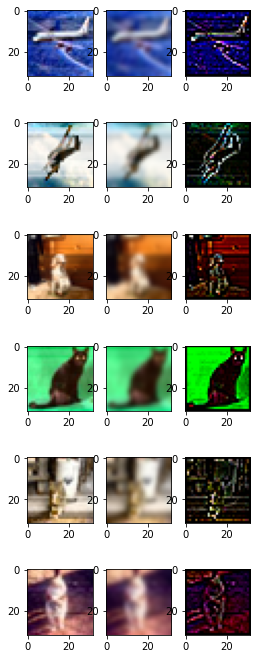

In [13]:
# visualize the filter responses
import matplotlib.pyplot as plt
n_images = 6
image_ids = np.arange(len(train_dataset))
np.random.shuffle(image_ids)
image_ids = image_ids[:n_images]

fig, ax = plt.subplots(n_images, 3, figsize=(4, 12))
for ii, im_id in enumerate(image_ids):
    im, _ = train_dataset[im_id]
    ax[ii, 0].imshow(im[0:3].numpy().transpose((1, 2, 0)))
    ax[ii, 1].imshow(im[3:6].numpy().transpose((1, 2, 0)))
    ax[ii, 2].imshow(im[6:9].numpy().transpose((1, 2, 0)))

In [14]:
# make loaders for training and validation data
batch_size = 8
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=8)

val_loader = DataLoader(val_dataset, batch_size=10)

In [15]:
# this is the initial MLP from the previous exercise
from utils import SimpleMLP

In [16]:
# instantiate the model
# note: we have more input features now;
# for each filter 3 additional channels are added to the model
n_filters = 3
n_input_channels = n_filters * 3 * 32 * 32
model = SimpleMLP(n_input_channels, 10)
model = model.to(device)

In [17]:
%tensorboard --logdir runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
Traceback (most recent call last):
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/bin/tensorboard", line 10, in <module>
    sys.exit(run_main())
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/tensorboard/main.py", line 65, in run_main
    default.get_plugins(),
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/tensorboard/default.py", line 113, in get_plugins
    return get_static_plugins() + get_dynamic_plugins()
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/tensorboard/default.py", line 151, in get_dynamic_plugins
    "tensorboard_plugins"
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/tensorboard/default.py", line 150, in <listcomp>
    for entry_point in

In [18]:
optimizer = Adam(model.parameters(), lr=1.e-4)
loss_function = nn.NLLLoss()
loss_function.to(device)

# you can find the results of this training run in the tensorboard
# above as well, they will have the name 'log_reg_filters1' and
# will be differently colored compared to the first model
tb_logger = SummaryWriter('runs/log_reg_filters1')

n_epochs = 4
for epoch in trange(n_epochs):
    utils.train(model, train_loader, loss_function, optimizer,
                device, epoch, tb_logger=tb_logger, log_image_interval=None)
    step = (epoch + 1) * len(train_loader)
    utils.validate(model, val_loader, loss_function, device, step,
                   tb_logger=tb_logger)

  0%|          | 0/4 [00:00<?, ?it/s]/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: Run

/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """


Test accuracy
0.4607



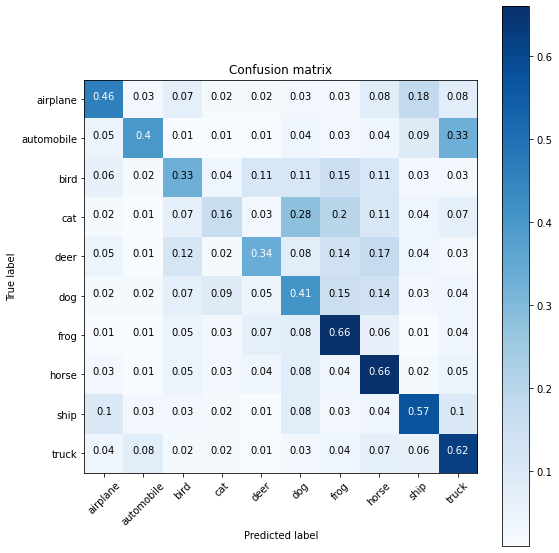

In [19]:
# evaluate the new model
test_dataset = utils.DatasetWithTransform(test_images, test_labels,
                                          transform=trafos)
test_loader = DataLoader(test_dataset, batch_size=25)

test_predictions, test_labels = utils.validate(model, test_loader, loss_function,
                                               device, 0, tb_logger=None)
accuracy = metrics.accuracy_score(test_labels, test_predictions)
print("Test accuracy")
print(accuracy)
print()

fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(test_labels,
                            test_predictions,
                            categories, ax)

## Expressing convolutional filters in pytorch

We can express both filters, gaussian and laplacian, as convolutional layers in pytorch.
Convolutional layers can be defined by [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).
They are usually used as layers with learnable parameters in convolutional neural networks; here, we will use them to express filters with preset and fixed kernels instead. 

In [124]:
# we will first define the gaussian filter as convolutional layer by computing the
# gaussian kernel matrix and then setting it as kernel for nn.Conv2d

# compute gaussian kernel for gaussian with sigma = 1
sigma = 1.
ksize = 5  # set the kernel size to 5

kernel = np.zeros((ksize, ksize), dtype='float32')

# compute the gaussian for each point in the kernel and then normalize it
for x in range(ksize):
    for y in range(ksize):
        exponent = ((x - ksize // 2) ** 2 + (y - ksize // 2) ** 2) / (2 * sigma * sigma)
        kernel[x, y] = np.exp(-exponent)
kernel /= kernel.sum()

# check the kernel
print(kernel)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.05963429 0.09832032 0.05963429 0.01330621]
 [0.02193823 0.09832032 0.1621028  0.09832032 0.02193823]
 [0.01330621 0.05963429 0.09832032 0.05963429 0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


In [125]:
# define the convolutional layer
c = nn.Conv2d(in_channels=3,  # we have 3 input channels
              out_channels=3,  # and also 3 output channels
              kernel_size=ksize,  # set the kernel size
              padding=2, padding_mode='reflect',  # pad the image to retain the same output as input size and use reflection padding
              bias=False) # deactivate the bias (data independent offset)

# now we need to set the kernel matrix to the gaussian kernel
with torch.no_grad():  # these operations should not incur gradients
    c.weight[:] = 0  # set allthe weights to zero
    # set the gaussian kernel only for the kernels that map input channel 1 to output channel 1 etc.
    for i in range(3):
         c.weight[i, i] = torch.from_numpy(kernel)

/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """


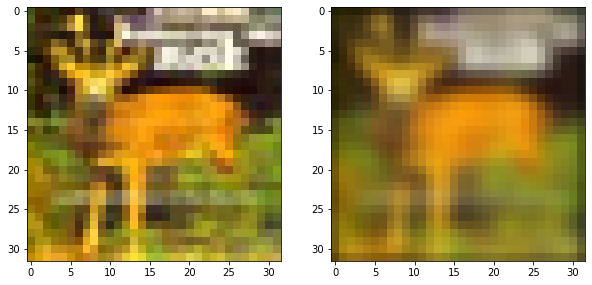

In [130]:
# apply the convolution and check the results visually
im, _ = train_dataset[0]
im = im[:3]
filtered = c(im.unsqueeze(0)).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(im.squeeze().numpy().transpose(1, 2, 0))
ax[1].imshow(filtered.detach().numpy().transpose((1, 2, 0)))

## Tasks and Questions

Tasks
- Express the laplacian using nn.Conv2d.
- Instead of applying the filters as transorms in the dataset, move them into the network using the formulation as nn.Conv2d from before. Rerun training, but keep the convolutional layers fixed! See below for how to implement your model for this.


In [ ]:
class MLPWithFilters(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.gauss = ''  # TODO add gaussian layer here
        self.laplace = ''  # TODO add laplacian layer here
        
        n_filters = 3
        self.n_inputs_mlp = n_filters * 3 * 32 * 32
        self.mlp = SimpleMLP(self.n_inputs_mlp, n_classes)
        
    def forward(self, x):
        # first, apply the filters and stack them across the channel axis
        x = torch.cat([
            x,  # keep the image in the first 3 channels
            self.gauss(x),  # gaussian in the next 3 channels
            self.laplace(x)  # laplacian in the final 3 channels
        ], dim=1)
        
        x = x.view(-1, self.n_inputs_mlp)
        x = self.mlp(x)

In [ ]:
# when we optimize the model, we ONLY train the mlp,not the filters.
# for this, we just pass the relevant subset of the models parameters to the optimizer
model = MLPWithFilters(10)
optimizer = Adam(MLPWithFilters.mlp.parameters(), lr=1e-3)